In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
%matplotlib inline

In [2]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [3]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [149]:
def fit_and_plot_a_country(country, src = pd.DataFrame(), p0_log =[5,20,40000], p0_exp = [0.5,0.5,0.5], cases = True ):
    if src.empty:
        if cases :
            try:
                df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv")
            except Exception as e:
                print("Data could not be fetched")
                print(e)
                return None
        else:
            # if cases is false, data calculated will be related to deaths
            try:
                df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_deaths.csv")
            except Exception as e:
                print("Data could not be fetched")
                print(e)
                return None
    else:
        df = src
    
    if country not in list(df.columns):
        print("Please check your country is in the data")
        return None
    
    df = df[['date',country]]
    df = df[True != df[country].isna()]
    df = df[df[country] > 0]
    last_updating = list(df.date)[-1]
    print("Last updating of data :",last_updating)
    df['date'] = df['date'].map(lambda x : (datetime.strptime(x, '%Y-%m-%d') - datetime.strptime("2020-01-01", '%Y-%m-%d')).days)
    x = list(df.iloc[:,0])
    y = list(df.iloc[:,1])
    if country == 'World':
        plt.plot(df.iloc[:,0], df.iloc[:,1],label="Real data",color="red", linestyle = 'dashed')
        plt.ylabel("Amount of infected people")
        plt.xlabel("Days from 1 January 2020")
        return None
    try:
        fit = curve_fit(logistic_model,x,y,p0=p0_log, maxfev=2000)
    except Exception as e:
        print("To get a result, please change the parameters in the list p0_log")
        print(e)
        return None
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    a,b,c = fit[0]
    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    print("Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): ")
    print("a = ", fit[0][0], " +/- ", errors[0])
    print("b = ", fit[0][1], " +/- ", errors[1])
    print("c = ", fit[0][2], " +/- ", errors[2] , "(This also means the amount of cases at the end.)" )
    first_day = datetime.strptime("2020-01-01", '%Y-%m-%d')
    last_day = first_day + timedelta(days=sol)
    last_day = datetime.strftime(last_day,'%Y-%m-%d')
    if cases:
        print("Last day of infections : ", last_day , " (approximately)")
    try:  
        exp_fit = curve_fit(exponential_model,x,y,p0=p0_exp)
    except Exception as e:
        print("To get a results, please change the parameters in the list p0_exp")
        print(e)
        return None
    pred_x = list(range(max(x),sol))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Actual DATA
    plt.scatter(df.iloc[:,0], df.iloc[:,1],label="Actual data", color="#2554C7")
    # Predicted DATA with logistic model
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic curve", alpha = 0.7, color="green")
    # Predicted DATA with exponential model
    plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential curve",alpha=0.6, color = "red")
    plt.legend()
    plt.xlabel("Days from 1 January 2020")
    if cases:
        plt.ylabel("Amount of infected people")
    else:
        plt.ylabel("Amount of deaths")   
    plt.ylim((min(y)*0.9,c*1.1))
    plt.show()
    return None
    

In [95]:
for i in pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv").columns:
    print(i)

date
World
Afghanistan
Albania
Algeria
Andorra
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei
Bulgaria
Burkina Faso
Cambodia
Cameroon
Canada
Central African Republic
Chile
China
Colombia
Congo
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Cyprus
Czech Republic
Democratic Republic of Congo
Denmark
Djibouti
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Estonia
Ethiopia
Finland
France
French Polynesia
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Guam
Guatemala
Guinea
Guyana
Honduras
Hungary
Iceland
India
Indonesia
International
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kosovo
Kuwait
Kyrgyzstan
Latvia
Lebanon
Liberia
Liechtenstein
Lithuania
Luxembourg
Macedonia
Malaysia
Maldives
Malta
Mauritania
Mexico
Moldova
Monaco
Mongolia
Montenegro
Morocco
Myanmar
Namibia
Nepal
Netherlands
New Zealand
Nicaragua
Nigeria
Norway
Oman
Pakistan
P

Last updating of data : 2020-03-19
Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): 
a =  4.785656276127625  +/-  0.17102350338102373
b =  79.59524038746068  +/-  0.9732053662311078
c =  85529.72183433335  +/-  10134.154383195231 (This also means the amount of cases at the end.)
Last day of infections :  2020-05-15  (approximately)


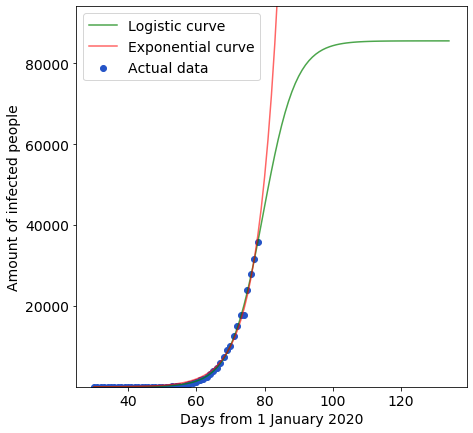

In [158]:
fit_and_plot_a_country(country = 'Italy')   